# Stock Prediction RNN

In this project, I will use Recurrent Neural Network regressor for a time series kind of prediction problem. Predict stock price of Apple company 7 days in advance.

The particular network I will use is Long Term Short Memory (LTSM) from RNN,

## Part 1: Loading the data





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import files
uploaded = files.upload()


Saving all_stocks_5yr.csv to all_stocks_5yr.csv


In [3]:
dataset = data = pd.read_csv('all_stocks_5yr.csv')


In [4]:
dataset

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [5]:
group = dataset[["Name"]].groupby("Name").value_counts()
group

Name
A       1259
AAL     1259
AAP     1259
AAPL    1259
ABBV    1259
        ... 
XYL     1259
YUM     1259
ZBH     1259
ZION    1259
ZTS     1259
Length: 505, dtype: int64

In [6]:
dataset_aapl = dataset[dataset['Name']=='AAPL'].close.values

In [7]:
dataset_aapl

array([ 67.8542,  68.5614,  66.8428, ..., 156.49  , 163.03  , 159.54  ])

In [8]:


dataset_aapl = dataset_aapl.reshape(dataset_aapl.shape[0], 1)

In [9]:
dataset_aapl

array([[ 67.8542],
       [ 68.5614],
       [ 66.8428],
       ...,
       [156.49  ],
       [163.03  ],
       [159.54  ]])

In [10]:
dataset_aapl.shape

(1259, 1)

#### Feature Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

dataset_aapl = sc.fit_transform(dataset_aapl)

In [12]:
dataset_aapl.shape

(1259, 1)

#### Slipt to squences for later training

Build the function to create 7 day slices

In [13]:
def processData(dataset, num_day):
  X, Y= [], []
  for i in range(len(dataset) - num_day - 1):
    X.append(dataset[i: (i + num_day), 0])
    Y.append(dataset[(i + num_day), 0])
  return np.array(X),np.array(Y)



In [14]:
X, Y = processData(dataset_aapl, 7)


In [15]:
X.shape

(1251, 7)

In [16]:
Y.shape

(1251,)

## Part 2: Split Train and Test

In [17]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
Y_train, Y_test = Y[:int(Y.shape[0]*0.80)],Y[int(Y.shape[0]*0.80):]

In [18]:
X_test

array([[0.53324732, 0.53097957, 0.5909131 , ..., 0.59358582, 0.60338576,
        0.61342868],
       [0.53097957, 0.5909131 , 0.5891313 , ..., 0.60338576, 0.61342868,
        0.61755923],
       [0.5909131 , 0.5891313 , 0.59358582, ..., 0.61342868, 0.61755923,
        0.6206369 ],
       ...,
       [0.9591804 , 0.93399212, 0.93723177, ..., 0.90046173, 0.90418733,
        0.90702202],
       [0.93399212, 0.93723177, 0.90847987, ..., 0.90418733, 0.90702202,
        0.84806038],
       [0.93723177, 0.90847987, 0.90046173, ..., 0.90702202, 0.84806038,
        0.81558288]])

In [19]:
X_test.shape

(251, 7)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
X_test.shape

(251, 1, 7)

In [24]:
X_test

array([[[0.53324732, 0.53097957, 0.5909131 , ..., 0.59358582,
         0.60338576, 0.61342868]],

       [[0.53097957, 0.5909131 , 0.5891313 , ..., 0.60338576,
         0.61342868, 0.61755923]],

       [[0.5909131 , 0.5891313 , 0.59358582, ..., 0.61342868,
         0.61755923, 0.6206369 ]],

       ...,

       [[0.9591804 , 0.93399212, 0.93723177, ..., 0.90046173,
         0.90418733, 0.90702202]],

       [[0.93399212, 0.93723177, 0.90847987, ..., 0.90418733,
         0.90702202, 0.84806038]],

       [[0.93723177, 0.90847987, 0.90046173, ..., 0.90702202,
         0.84806038, 0.81558288]]])

## Part 3: Build the RNN regression Model

Build Kera RNN Model

In [25]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

Set up the hyperparameter and set loss function and optimiser

In [26]:
# Global variable
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
#Ensure I use GPU
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [27]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

See the trainning process and the improvment from backpropagation and optimization

In [29]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
Y_test_cuda = torch.tensor(Y_test).float().cuda()

# I use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(Y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters

    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), Y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.0008318363688886166, eval loss 0.00738941365852952
epoch 1, loss 0.0007848048117011786
epoch 2, loss 0.0008311158162541687
epoch 3, loss 0.0008463201811537147
epoch 4, loss 0.0008882716065272689
epoch 5, loss 0.0008189526852220297
epoch 6, loss 0.0009578182944096625
epoch 7, loss 0.0008224462508223951
epoch 8, loss 0.0008354662568308413
epoch 9, loss 0.0008976383833214641
epoch 10, loss 0.0008486169390380383
epoch 11, loss 0.0008852693717926741
epoch 12, loss 0.000781087321229279
epoch 13, loss 0.0007828527013771236
epoch 14, loss 0.0008098621619865298
epoch 15, loss 0.0008305225055664778
epoch 16, loss 0.0007797569269314408
epoch 17, loss 0.0008505975129082799
epoch 18, loss 0.0007604268030263484
epoch 19, loss 0.000825191440526396
epoch 20, loss 0.0008141579455696046, eval loss 0.007426807656884193
epoch 21, loss 0.0008165922481566668
epoch 22, loss 0.0008656353456899524
epoch 23, loss 0.0007459435728378594
epoch 24, loss 0.0007826372748240829
epoch 25, loss 0.0007927

The weight parameters

In [30]:
rnn.out.weight

Parameter containing:
tensor([[-0.0357, -0.0060,  0.0531, -0.0522, -0.0624,  0.0344, -0.0842,  0.0137,
         -0.0555, -0.0361, -0.0785, -0.0693, -0.0136, -0.0993,  0.0036,  0.0002,
         -0.0983, -0.0098,  0.0506, -0.0433,  0.0159,  0.0661, -0.1243,  0.0835,
          0.1135,  0.0390,  0.0091, -0.0788, -0.1135, -0.0958,  0.1234, -0.0744,
         -0.0354,  0.0180, -0.0447,  0.0463,  0.0485,  0.0048,  0.0825,  0.1021,
          0.0757, -0.0914, -0.0502, -0.0871,  0.0207,  0.0198, -0.0488, -0.0591,
          0.0550,  0.0972,  0.1209, -0.0242,  0.1109,  0.1262, -0.1129, -0.0255,
          0.0593,  0.0145, -0.0219,  0.0645, -0.0756, -0.1106, -0.0599, -0.1061]],
       device='cuda:0', requires_grad=True)

In [31]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0442, -0.0560, -0.0541,  ...,  0.0784,  0.0145,  0.0439],
        [ 0.1228,  0.1314,  0.0638,  ...,  0.0004,  0.0660,  0.0191],
        [ 0.0082, -0.0340,  0.1239,  ..., -0.0541,  0.1702, -0.0335],
        ...,
        [ 0.0612, -0.0240,  0.0861,  ..., -0.0828,  0.1341,  0.0092],
        [-0.0750,  0.0770, -0.0614,  ...,  0.0803,  0.1162,  0.0220],
        [ 0.1272, -0.0060,  0.1420,  ...,  0.1448, -0.0809, -0.0818]],
       device='cuda:0')
tensor([[-0.0572,  0.1178, -0.0581,  ..., -0.0225, -0.0854, -0.1316],
        [ 0.0090, -0.0349,  0.0759,  ..., -0.0868,  0.0283, -0.0155],
        [ 0.0388,  0.0858, -0.1299,  ...,  0.1220, -0.1409,  0.0488],
        ...,
        [ 0.1081,  0.0895, -0.0685,  ...,  0.0280,  0.0935,  0.0702],
        [ 0.0998, -0.0645, -0.0929,  ...,  0.1204,  0.0504,  0.0246],
        [-0.0019, -0.0648,  0.0741,  ...,  0.1583,  0.0323, -0.0643]],
       device='cuda:0')
tensor([-0.0690, -0.1006,  0.0649,  0.0366, -0.0803,  0.1241, -0.0665, -0.1034,
    

The visualization of the improvment of the loss.

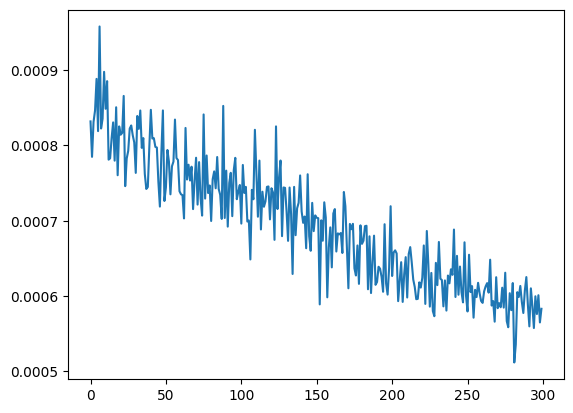

In [32]:
plt.plot(history)

## Part 4: RNN regression Model Evaluation and stock Prediction

Predict the test set

In [34]:
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [35]:
test_predict_cpu.shape

(251, 1, 1)

Use Inverse transform to transform back the data to original value

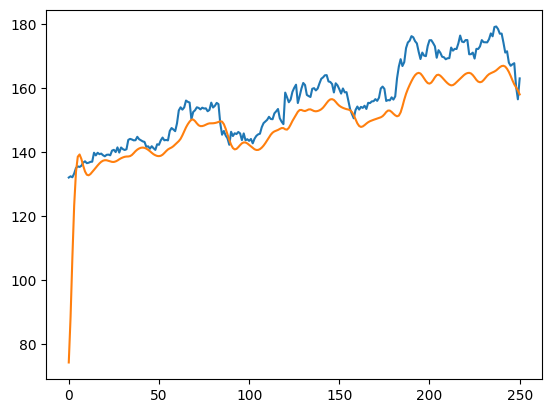

In [36]:
plt.plot(sc.inverse_transform(Y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

Plot Tran/test and prediction for the test set part

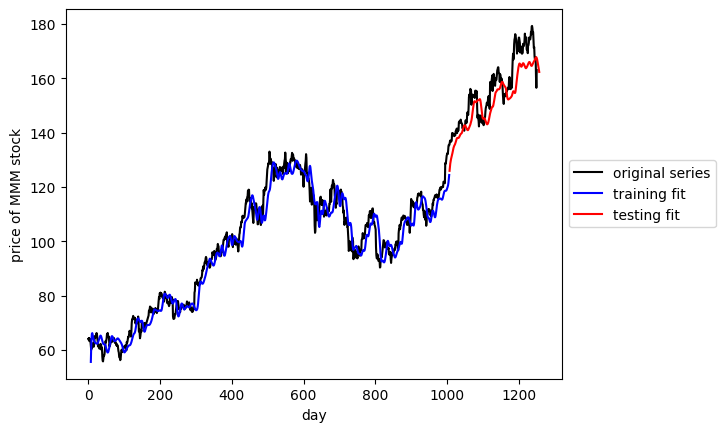

In [ ]:
# plot original data
plt.plot(sc.inverse_transform(Y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In conclusion, It seems that the LSTM did predict the partern very well and have a same partern as the grand true. And there is just a bit different from prediction and the grand true.